# Using pre-trained models to make predictions on new images

Before I ran this notebook I had to set things up. I did this using a conda environment. However, for some reason this did not allow darknet to use OpenCV, but everything else seemed to work. Here are the lines that I ran in the terminal after creating the conda environment. Note that when i created the environment, a bunch of resources were installed as default, and I dont know what those were.

With this done we should be able to continue using this notebook. First we import all the modules that we need. If you get errors here you will need to install any missing modules with 'conda install <missing module>'

In [162]:
import cv2
import os.path
import glob
import random
import matplotlib.pyplot as plt
import pandas as pd

# Define all acepted image file extensions
ext = ['png', 'jpg', 'JPG', 'jpeg', 'gif']

# create random colours to use for different classes
cols = []
for i in list(range(0, 100)):
    cols.append([(round(random.random()*255), round(random.random()*255), round(random.random()*255))])

This defines a function that we can use to display an image on the disk, in this notebook

In [4]:
%matplotlib inline
def imShow(path):
  image = cv2.imread(path)
  height, width = image.shape[:2]
  #resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)
  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

Let's see if we can get it to work with the COCO weights first. These are the default weight (detection algorithm), which can identify dogs bikes, cars etc. This next line is a command line instruction (preceeded with a % or !), and the %%capture can be used to stop the chunk from printing all of its outputs.

In [7]:
#%%capture
%cd darknet/ 
!./darknet detect cfg/yolov4.cfg yolov4.weights data/PXL_20220308_074613409.jpg
%cd ..

/data/notebooks/jupyterlab-yolov4/darknet
 GPU isn't used 
 Used AVX 
 Used FMA & AVX2 
 OpenCV isn't used - data augmentation will be slow 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   9 route  8 2 	                     

Now show the prediction

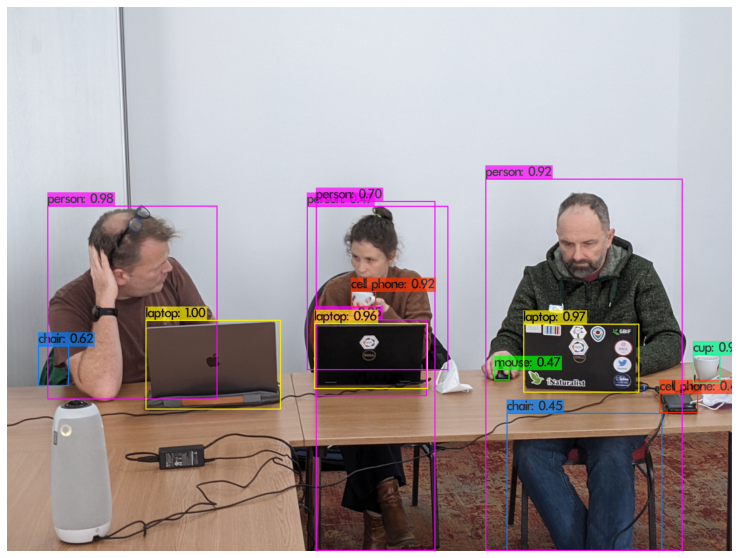

In [5]:
imShow('darknet/predictions.jpg')

With this running at hte command line we can now move to using the cv2 module in python which allows us to do a few more things.

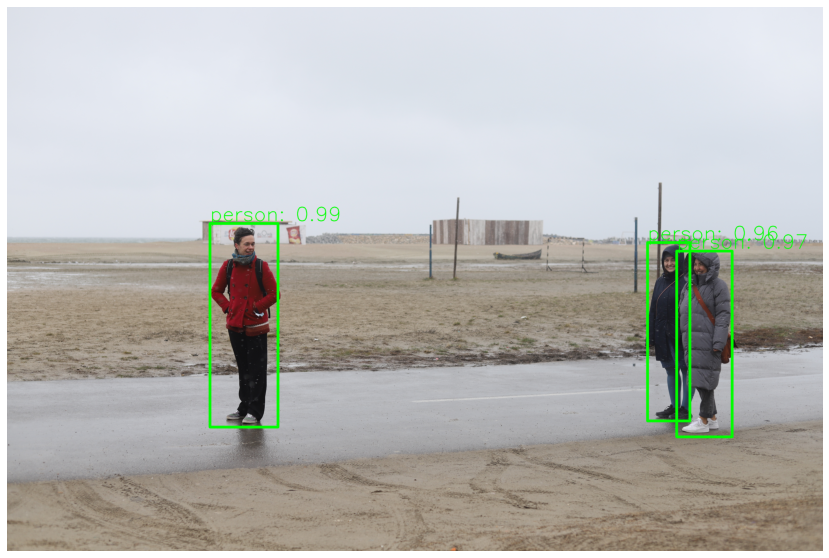

In [126]:
# Load in the image
img = cv2.imread('darknet/data/pavel_images/IMG_7778.jpg')

# Correct the colour
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Read in the classes
with open('darknet/data/coco.names', 'r') as f:
    classes = f.read().splitlines()

# Load in the model    
net = cv2.dnn.readNetFromDarknet('darknet/cfg/yolov4.cfg', 'darknet/yolov4.weights')
model = cv2.dnn_DetectionModel(net)
model.setInputParams(scale=1 / 255, size=(416, 416), swapRB=False)

# Run the detection
classIds, scores, boxes = model.detect(img, confThreshold=0.6, nmsThreshold=0.4)

# For each detection add teh box and classification to the image
for (classId, score, box) in zip(classIds, scores, boxes):
    cv2.rectangle(img, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]),
                  color=(0, 255, 0), thickness=20)
 
    text = '%s: %.2f' % (classes[classId], score)
    cv2.putText(img, text, (box[0], box[1] - 20), cv2.FONT_HERSHEY_SIMPLEX, 5,
                color=(0, 255, 0), thickness=5)

# Create a plot in this notebook to show the result
fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.axis("off")
plt.imshow(img)

Now we take a big step and write this into a function that does a lot of other things

In [148]:
# Create a function to run a pretrained model
def detect_image(image_paths, # path to images
                 results_path, # path where to save resuts
                 plot = True, # Plot or not?
                 scale_image = 20, # rescale saved image (50 = half the size of original)
                 bbox_thickness = 20, # thickness of bbox line
                 text_size = 2, # text size
                 text_thickness = 2, # text line thickness
                 confThreshold = 0.6, # predictions with a value lower than this will be ignored
                 nmsThreshold = 0.4, # predictions overlapping more than this (and same class) will be removed
                 class_names_file = 'darknet/data/coco.names', # file that contains list of classes
                 cfg_file = 'darknet/cfg/yolov4.cfg', # file with model configuration
                 weights_file = 'darknet/yolov4.weights'): # file with model weights
    
    # read in the class file
    with open(class_names_file, 'r') as f:
        classes = f.read().splitlines()
    
    # read in the model
    net = cv2.dnn.readNetFromDarknet(cfg_file, weights_file)
    model = cv2.dnn_DetectionModel(net)
    model.setInputParams(scale=1 / 255, size=(416, 416), swapRB = False)
    
    # Make the results directory if it is missing
    if os.path.isdir(results_path) == False:
        os.mkdir(results_path)
    
    # for each image
    for image_path in image_paths:        
        
        print(os.path.basename(image_path))
        
        # read in image and correct colour
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # run detection
        classIds, scores, boxes = model.detect(img,
                                               confThreshold = confThreshold,
                                               nmsThreshold = nmsThreshold)
        
        # for each prediction add it to the image
        for (classId, score, box) in zip(classIds, scores, boxes):
                          
            cv2.rectangle(img, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]),
                          color=cols[classId][0], thickness = bbox_thickness)

            text = '%s: %.2f' % (classes[classId], score)
            cv2.putText(img, text, (box[0], box[1] - 20), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                        color=cols[classId][0], thickness = text_thickness)
            
        print(str(len(classIds)) + ' objects detected')

        # If anything is found save data to csv
        if len(classIds) > 0:

            # save the data to csv
            list_of_truples = list(zip(classIds, scores, boxes))

            # Converting lists of tuples into
            # pandas Dataframe.
            df = pd.DataFrame(list_of_truples,
                              columns = ['classIds', 'scores', 'boxes'])

            # save
            df_name = 'df_' + os.path.basename(image_path) + '.csv'
            df.to_csv(results_path + '/' + df_name, 
                      index = False)

            
        if plot == False:
            basename = 'P_' + os.path.basename(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            # rescale
            #calculate the 50 percent of original dimensions
            width = int(img.shape[1] * scale_image / 100)
            height = int(img.shape[0] * scale_image / 100)

            # dsize
            dsize = (width, height)

            # resize image
            output = cv2.resize(img, dsize)
            cv2.imwrite(results_path + '/' + basename, output)

        if plot == True:

            print(df)

            fig = plt.gcf()
            #fig.set_size_inches(18, 10)
            plt.axis("off")
            plt.imshow(img)
            basename = 'P_' + os.path.basename(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            # rescale
            #calculate the 50 percent of original dimensions
            width = int(img.shape[1] * scale_percent / 100)
            height = int(img.shape[0] * scale_percent / 100)

            # dsize
            dsize = (width, height)

            # resize image
            output = cv2.resize(img, dsize)
            cv2.imwrite(results_path + '/' + basename, output)
            

In [161]:
# Test teh function on a couple of images
detect_image(('darknet/data/tests/PXL_20220308_074613409.jpg','darknet/data/tests/group.jpg'),
             'darknet/data/tests/results',
             plot = False, text_size = 5, text_thickness = 5)

PXL_20220308_074613409.jpg
8 objects detected
group.jpg
14 objects detected


## Test function on a list of images

In [129]:
images_pav = []
[images_pav.extend(glob.glob('darknet/data/pavel_images/' + '*.' + e)) for e in ext]
print(images_pav)

['darknet/data/pavel_images/IMG_7781.jpg', 'darknet/data/pavel_images/IMG_7773.jpg', 'darknet/data/pavel_images/IMG_7797.jpg', 'darknet/data/pavel_images/IMG_7794.jpg', 'darknet/data/pavel_images/IMG_7749.jpg', 'darknet/data/pavel_images/IMG_7783.jpg', 'darknet/data/pavel_images/IMG_7778.jpg', 'darknet/data/pavel_images/IMG_7753.jpg', 'darknet/data/pavel_images/IMG_7747.jpg', 'darknet/data/pavel_images/IMG_7744.jpg']


Now detect on multiple. Make sure you create your results folder first!

In [130]:
detect_image(images_pav,
             'darknet/data/pavel_images/results/',
             plot = False)

IMG_7781.jpg
7 objects detected
IMG_7773.jpg
1 objects detected
IMG_7797.jpg
4 objects detected
IMG_7794.jpg
2 objects detected
IMG_7749.jpg
2 objects detected
IMG_7783.jpg
6 objects detected
IMG_7778.jpg
3 objects detected
IMG_7753.jpg
1 objects detected
IMG_7747.jpg
7 objects detected
IMG_7744.jpg
3 objects detected


In [46]:
images_test = []
[images_test.extend(glob.glob('darknet/data/tests/' + '*.' + e)) for e in ext]
print(images_test)

['darknet/data/tests/group.jpg']


In [47]:
detect_image(images_test,
             'darknet/data/tests/results/',
             plot = False,
             bbox_thickness = 3,
             confThreshold = 0.2,
             nmsThreshold = 0.6,
             scale_image = 60, 
             text_size=2)

group.jpg


## Do some of esras images

In [38]:
ext = ['png', 'jpg', 'JPG', 'jpeg', 'gif'] 
images_esra = []
[images_esra.extend(glob.glob('darknet/data/esra_images/' + '*.' + e)) for e in ext]
print(images_esra)

['darknet/data/esra_images/Two bear.png', 'darknet/data/esra_images/Duygu_Ozalp_RRP.jpg', 'darknet/data/esra_images/Omer_Guvercin_RRP.jpg', 'darknet/data/esra_images/Cumhur_Palas_Alexandrine_parakeet.jpg', 'darknet/data/esra_images/Srgnc_RRP.jpg', 'darknet/data/esra_images/CumhurPalas_Alex_Parakeet.jpg', 'darknet/data/esra_images/Rahmi_Tasci_RRP.jpg', 'darknet/data/esra_images/Sibel_Bostancioglu_RRP.jpg', 'darknet/data/esra_images/Handan_Inci_RoseRingedParakeet.jpg', 'darknet/data/esra_images/Cengiz_Kayacilar_StrayDogs_NationalPark_.JPG']


In [39]:
detect_image(images_esra,
             'darknet/data/esra_images/results/',
             plot = False,
             bbox_thickness = 3,
             confThreshold = 0.2,
             nmsThreshold = 0.6,
             scale_image = 60, 
             text_size=2)

Two bear.png
Duygu_Ozalp_RRP.jpg
Omer_Guvercin_RRP.jpg
Cumhur_Palas_Alexandrine_parakeet.jpg
Srgnc_RRP.jpg
CumhurPalas_Alex_Parakeet.jpg
Rahmi_Tasci_RRP.jpg
Sibel_Bostancioglu_RRP.jpg
Handan_Inci_RoseRingedParakeet.jpg
Cengiz_Kayacilar_StrayDogs_NationalPark_.JPG


## Run on video frames

There is supposed to be support for video but i could not get it to work so instead i take the video, split it into frames, predict on the frames, then compile the frames into a video. the video is a large AVI which i then compress to an mp4 using ffmpeg

In [94]:
# Resize the original video, its a bit big
import moviepy.editor as mp
clip = mp.VideoFileClip("darknet/data/video/test2.mp4")
clip_resized = clip.resize(height=720) # make the height 360px ( According to moviePy documenation The width is then computed so that the width/height ratio is conserved.)
clip_resized.write_videofile("darknet/data/video/test3.mp4")

Moviepy - Building video darknet/data/video/test3.mp4.
MoviePy - Writing audio in test3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video darknet/data/video/test3.mp4



Moviepy - Done !
Moviepy - video ready darknet/data/video/test3.mp4


In [99]:
# seperate the video into frames
vidcap = cv2.VideoCapture("darknet/data/video/test3.mp4")
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("darknet/data/video/frame%04d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

In [100]:
# Now, get an array of all the file names
images_vid = []
[images_vid.extend(glob.glob('darknet/data/video/' + '*.' + e)) for e in ext]
#print(images_vid)

[None, None, None, None, None]

In [163]:
# Run the model across all of the frames
detect_image(sorted(images_vid),
             'darknet/data/video/results/',
             plot = False,
             bbox_thickness = 3,
             confThreshold = 0.6,
             nmsThreshold = 0.6,
             scale_image = 100, 
             text_size = 1,
             text_thickness = 2)

frame0000.jpg
11 objects detected
frame0001.jpg
11 objects detected
frame0002.jpg
8 objects detected
frame0003.jpg
11 objects detected
frame0004.jpg
11 objects detected
frame0005.jpg
11 objects detected
frame0006.jpg
11 objects detected
frame0007.jpg
10 objects detected
frame0008.jpg
10 objects detected
frame0009.jpg
11 objects detected
frame0010.jpg
10 objects detected
frame0011.jpg
12 objects detected
frame0012.jpg
11 objects detected
frame0013.jpg
11 objects detected
frame0014.jpg
11 objects detected
frame0015.jpg
13 objects detected
frame0016.jpg
13 objects detected
frame0017.jpg
12 objects detected
frame0018.jpg
10 objects detected
frame0019.jpg
8 objects detected
frame0020.jpg
10 objects detected
frame0021.jpg
6 objects detected
frame0022.jpg
9 objects detected
frame0023.jpg
11 objects detected
frame0024.jpg
10 objects detected
frame0025.jpg
10 objects detected
frame0026.jpg
8 objects detected
frame0027.jpg
9 objects detected
frame0028.jpg
11 objects detected
frame0029.jpg
11 obj

In [164]:
# save as a video
# note I had problems with the mp4 format so instead save as avi and convert to mp4 next
image_folder = 'darknet/data/video/results/'
#video_name = 'darknet/data/video/video.mp4'
video_name = 'darknet/data/video/video.avi'

images = sorted([img for img in os.listdir(image_folder) if img.endswith(".jpg")])
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

#video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 24, (width,height))
video = cv2.VideoWriter(video_name, 0, 24, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

In [165]:
# Install ffmpeg if you dont have it, then convert to mp4
#!conda install -y ffmpeg
!ffmpeg -y -i darknet/data/video/video.avi darknet/data/video/video.mp4

ffmpeg version 9c33b2f Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavfor

## Try running on a custom network

Now to run on a custom network, thi is the one we have developed for Crepipatella dilatata

In [54]:
images_CD = []
[images_CD.extend(glob.glob('darknet/data/CD_test/' + '*.' + e)) for e in ext]
print(images_CD)

['darknet/data/CD_test/group.jpg', 'darknet/data/CD_test/large (1).jpg', 'darknet/data/CD_test/large.jpg', 'darknet/data/CD_test/large (1).jpeg', 'darknet/data/CD_test/large (3).jpeg', 'darknet/data/CD_test/large (2).jpeg', 'darknet/data/CD_test/large.jpeg']


In [55]:
# Run the new model (note the last three arguments)
detect_image(images_CD,
             'darknet/data/CD_test/results',
             plot = False,
             bbox_thickness = 3,
             confThreshold = 0.2,
             nmsThreshold = 0.2,
             scale_image = 60, 
             text_size = 2,
             class_names_file = 'yolov4_Cd2classes/obj.names.txt',
             cfg_file = 'yolov4_Cd2classes/yolov4-custom.cfg',
             weights_file = 'yolov4-custom_330.weights')

group.jpg
large (1).jpg
large.jpg
large (1).jpeg
large (3).jpeg
large (2).jpeg
large.jpeg


## Detect parakeets

Here we run using the original coco weights (not our Crepipatella dilatata model), to see if we can count parakeets

In [ ]:
images_p = []
[images_p.extend(glob.glob('/data/notebooks/rstudio-pavel/portugese_photos/' + '*.' + e)) for e in ext]
print(images_p)

In [ ]:
detect_image(images_p[0:100],
             '/data/notebooks/rstudio-pavel/portugese_photos/results',
             plot = False,
             bbox_thickness = 3,
             confThreshold = 0.2,
             nmsThreshold = 0.2,
             scale_image = 60, 
             text_size = 2,
             class_names_file = 'yolov4_Cd2classes/obj.names.txt',
             cfg_file = 'yolov4_Cd2classes/yolov4-custom.cfg',
             weights_file = 'yolov4-custom_330.weights')